## Load Data

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import numpy as np

torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size = 512
num_epochs = 300
lr = 0.01

In [ ]:
train_dataset = FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size)

## Train Some Layers

In [ ]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x


class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [ ]:
first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

## Train 1

In [ ]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(100):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{100}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/100, Train_Loss: 2.3022, Train_Acc: 0.1454, Validation Loss: 2.2960, Val_Acc: 0.1692
Epoch 2/100, Train_Loss: 2.2944, Train_Acc: 0.1849, Validation Loss: 2.2925, Val_Acc: 0.1988
Epoch 3/100, Train_Loss: 2.2909, Train_Acc: 0.2187, Validation Loss: 2.2889, Val_Acc: 0.2219
Epoch 4/100, Train_Loss: 2.2871, Train_Acc: 0.2487, Validation Loss: 2.2850, Val_Acc: 0.3271
Epoch 5/100, Train_Loss: 2.2830, Train_Acc: 0.3197, Validation Loss: 2.2806, Val_Acc: 0.2862
Epoch 6/100, Train_Loss: 2.2784, Train_Acc: 0.3260, Validation Loss: 2.2760, Val_Acc: 0.2779
Epoch 7/100, Train_Loss: 2.2734, Train_Acc: 0.2968, Validation Loss: 2.2705, Val_Acc: 0.4204
Epoch 8/100, Train_Loss: 2.2677, Train_Acc: 0.3700, Validation Loss: 2.2646, Val_Acc: 0.4153
Epoch 9/100, Train_Loss: 2.2612, Train_Acc: 0.3940, Validation Loss: 2.2575, Val_Acc: 0.4507
Epoch 10/100, Train_Loss: 2.2537, Train_Acc: 0.4049, Validation Loss: 2.2496, Val_Acc: 0.4059
Epoch 11/100, Train_Loss: 2.2450, Train_Acc: 0.4127, Validation Loss:

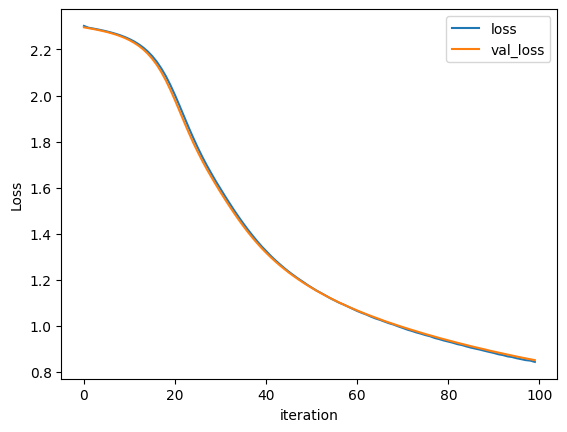

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

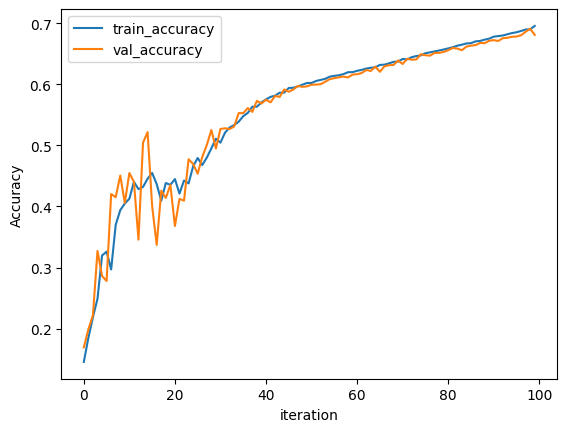

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Train 2

In [ ]:
for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(100):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{100}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/100, Train_Loss: 2.3067, Train_Acc: 0.1056, Validation Loss: 2.3012, Val_Acc: 0.1667
Epoch 2/100, Train_Loss: 2.3010, Train_Acc: 0.1172, Validation Loss: 2.3006, Val_Acc: 0.1000
Epoch 3/100, Train_Loss: 2.3004, Train_Acc: 0.1394, Validation Loss: 2.2999, Val_Acc: 0.1512
Epoch 4/100, Train_Loss: 2.2998, Train_Acc: 0.1461, Validation Loss: 2.2993, Val_Acc: 0.1000
Epoch 5/100, Train_Loss: 2.2990, Train_Acc: 0.1418, Validation Loss: 2.2986, Val_Acc: 0.2553
Epoch 6/100, Train_Loss: 2.2984, Train_Acc: 0.1628, Validation Loss: 2.2978, Val_Acc: 0.1061
Epoch 7/100, Train_Loss: 2.2976, Train_Acc: 0.1730, Validation Loss: 2.2972, Val_Acc: 0.1169
Epoch 8/100, Train_Loss: 2.2969, Train_Acc: 0.1842, Validation Loss: 2.2963, Val_Acc: 0.1125
Epoch 9/100, Train_Loss: 2.2960, Train_Acc: 0.1953, Validation Loss: 2.2956, Val_Acc: 0.1849
Epoch 10/100, Train_Loss: 2.2952, Train_Acc: 0.1831, Validation Loss: 2.2946, Val_Acc: 0.1000
Epoch 11/100, Train_Loss: 2.2943, Train_Acc: 0.1863, Validation Loss:

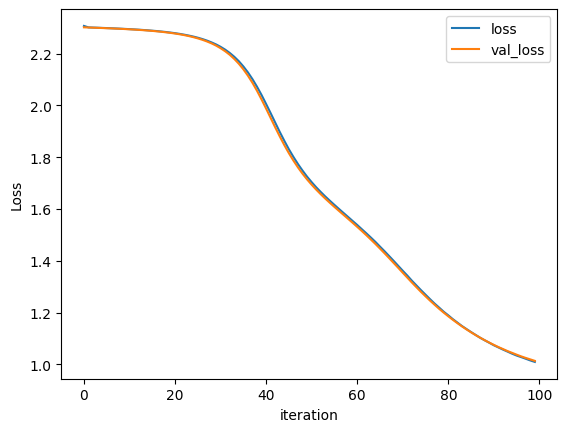

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

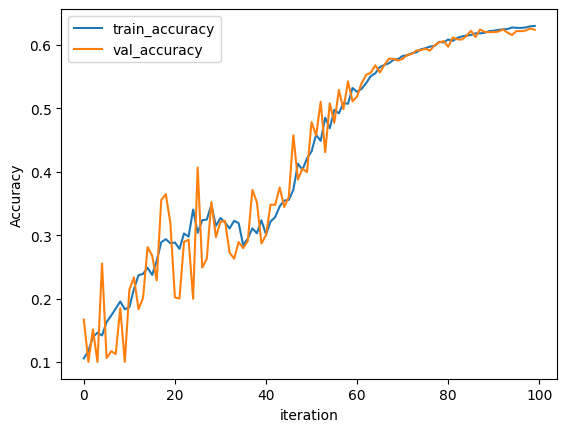

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Train 3

In [ ]:
for param in first.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(100):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{100}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/100, Train_Loss: 2.0947, Train_Acc: 0.3137, Validation Loss: 1.9280, Val_Acc: 0.4186
Epoch 2/100, Train_Loss: 1.8181, Train_Acc: 0.4889, Validation Loss: 1.7254, Val_Acc: 0.5162
Epoch 3/100, Train_Loss: 1.6553, Train_Acc: 0.5296, Validation Loss: 1.5960, Val_Acc: 0.5259
Epoch 4/100, Train_Loss: 1.5458, Train_Acc: 0.5366, Validation Loss: 1.5040, Val_Acc: 0.5424
Epoch 5/100, Train_Loss: 1.4658, Train_Acc: 0.5444, Validation Loss: 1.4348, Val_Acc: 0.5591
Epoch 6/100, Train_Loss: 1.4036, Train_Acc: 0.5542, Validation Loss: 1.3803, Val_Acc: 0.5337
Epoch 7/100, Train_Loss: 1.3541, Train_Acc: 0.5550, Validation Loss: 1.3361, Val_Acc: 0.5560
Epoch 8/100, Train_Loss: 1.3139, Train_Acc: 0.5619, Validation Loss: 1.2999, Val_Acc: 0.5565
Epoch 9/100, Train_Loss: 1.2794, Train_Acc: 0.5648, Validation Loss: 1.2687, Val_Acc: 0.5670
Epoch 10/100, Train_Loss: 1.2503, Train_Acc: 0.5726, Validation Loss: 1.2421, Val_Acc: 0.5769
Epoch 11/100, Train_Loss: 1.2255, Train_Acc: 0.5761, Validation Loss:

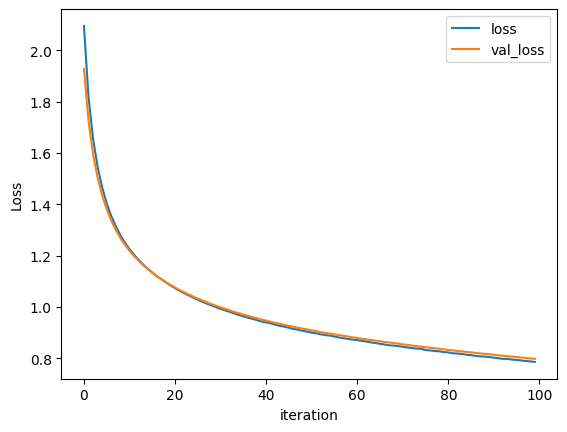

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

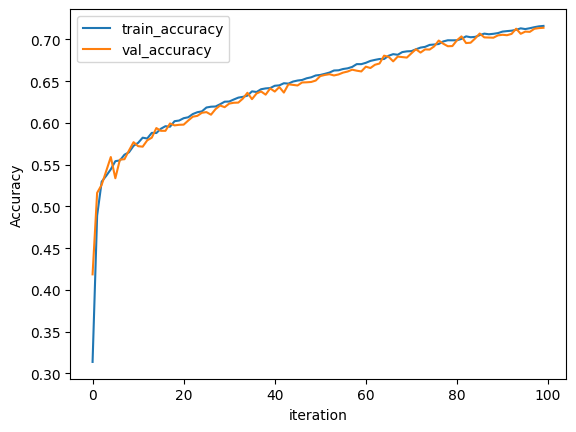

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Train 4

In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(100):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{100}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/100, Train_Loss: 2.3041, Train_Acc: 0.0984, Validation Loss: 2.3019, Val_Acc: 0.0005
Epoch 2/100, Train_Loss: 2.3015, Train_Acc: 0.1041, Validation Loss: 2.3010, Val_Acc: 0.1178
Epoch 3/100, Train_Loss: 2.3006, Train_Acc: 0.1265, Validation Loss: 2.3001, Val_Acc: 0.1000
Epoch 4/100, Train_Loss: 2.2996, Train_Acc: 0.1336, Validation Loss: 2.2990, Val_Acc: 0.1000
Epoch 5/100, Train_Loss: 2.2986, Train_Acc: 0.1381, Validation Loss: 2.2981, Val_Acc: 0.1949
Epoch 6/100, Train_Loss: 2.2976, Train_Acc: 0.1879, Validation Loss: 2.2969, Val_Acc: 0.1998
Epoch 7/100, Train_Loss: 2.2965, Train_Acc: 0.1621, Validation Loss: 2.2958, Val_Acc: 0.1791
Epoch 8/100, Train_Loss: 2.2953, Train_Acc: 0.1641, Validation Loss: 2.2947, Val_Acc: 0.2774
Epoch 9/100, Train_Loss: 2.2941, Train_Acc: 0.2239, Validation Loss: 2.2934, Val_Acc: 0.2277
Epoch 10/100, Train_Loss: 2.2928, Train_Acc: 0.2225, Validation Loss: 2.2920, Val_Acc: 0.1973
Epoch 11/100, Train_Loss: 2.2913, Train_Acc: 0.2338, Validation Loss:

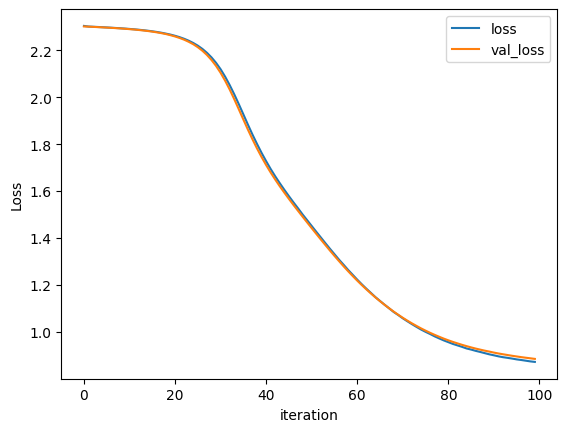

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

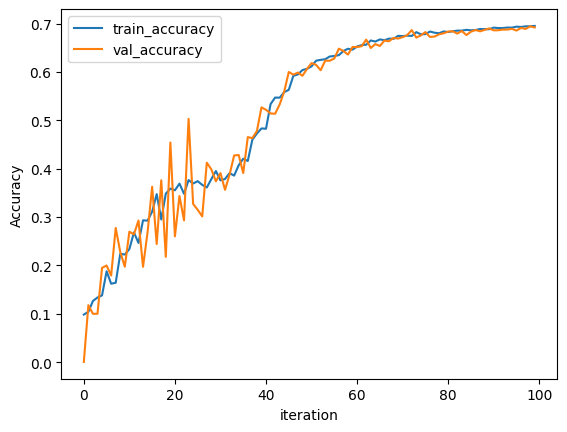

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Train 5

In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(100):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{100}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/100, Train_Loss: 2.0434, Train_Acc: 0.3677, Validation Loss: 1.8427, Val_Acc: 0.4908
Epoch 2/100, Train_Loss: 1.7166, Train_Acc: 0.5390, Validation Loss: 1.6136, Val_Acc: 0.5560
Epoch 3/100, Train_Loss: 1.5366, Train_Acc: 0.5666, Validation Loss: 1.4730, Val_Acc: 0.5796
Epoch 4/100, Train_Loss: 1.4197, Train_Acc: 0.5848, Validation Loss: 1.3769, Val_Acc: 0.5905
Epoch 5/100, Train_Loss: 1.3364, Train_Acc: 0.6000, Validation Loss: 1.3068, Val_Acc: 0.5904
Epoch 6/100, Train_Loss: 1.2737, Train_Acc: 0.6048, Validation Loss: 1.2532, Val_Acc: 0.5992
Epoch 7/100, Train_Loss: 1.2254, Train_Acc: 0.6174, Validation Loss: 1.2109, Val_Acc: 0.6013
Epoch 8/100, Train_Loss: 1.1864, Train_Acc: 0.6193, Validation Loss: 1.1765, Val_Acc: 0.6093
Epoch 9/100, Train_Loss: 1.1540, Train_Acc: 0.6248, Validation Loss: 1.1477, Val_Acc: 0.6203
Epoch 10/100, Train_Loss: 1.1273, Train_Acc: 0.6300, Validation Loss: 1.1231, Val_Acc: 0.6409
Epoch 11/100, Train_Loss: 1.1037, Train_Acc: 0.6365, Validation Loss:

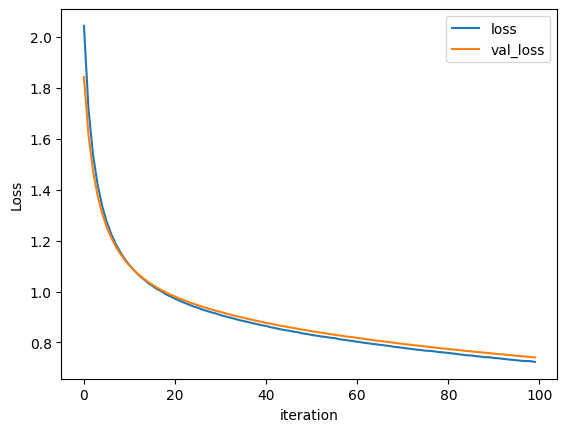

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

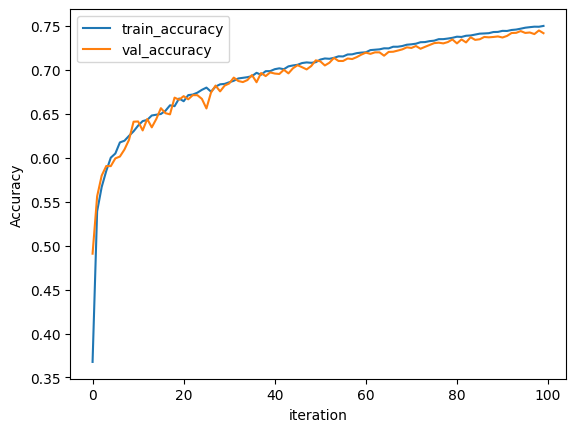

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Train 6

In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
for param in third.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(100):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{100}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/100, Train_Loss: 2.2908, Train_Acc: 0.2117, Validation Loss: 2.2685, Val_Acc: 0.3769
Epoch 2/100, Train_Loss: 2.2510, Train_Acc: 0.4314, Validation Loss: 2.2326, Val_Acc: 0.4873
Epoch 3/100, Train_Loss: 2.2121, Train_Acc: 0.5056, Validation Loss: 2.1899, Val_Acc: 0.5373
Epoch 4/100, Train_Loss: 2.1646, Train_Acc: 0.5296, Validation Loss: 2.1377, Val_Acc: 0.5368
Epoch 5/100, Train_Loss: 2.1068, Train_Acc: 0.5386, Validation Loss: 2.0739, Val_Acc: 0.5502
Epoch 6/100, Train_Loss: 2.0372, Train_Acc: 0.5667, Validation Loss: 1.9989, Val_Acc: 0.5514
Epoch 7/100, Train_Loss: 1.9573, Train_Acc: 0.5775, Validation Loss: 1.9156, Val_Acc: 0.5590
Epoch 8/100, Train_Loss: 1.8712, Train_Acc: 0.5846, Validation Loss: 1.8283, Val_Acc: 0.6143
Epoch 9/100, Train_Loss: 1.7837, Train_Acc: 0.6101, Validation Loss: 1.7419, Val_Acc: 0.6048
Epoch 10/100, Train_Loss: 1.6989, Train_Acc: 0.6166, Validation Loss: 1.6599, Val_Acc: 0.5936
Epoch 11/100, Train_Loss: 1.6198, Train_Acc: 0.6182, Validation Loss:

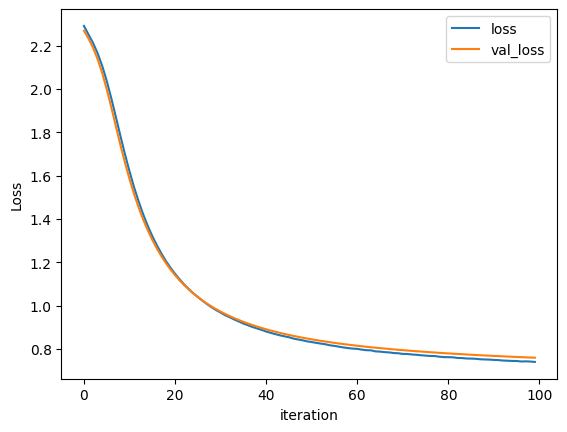

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

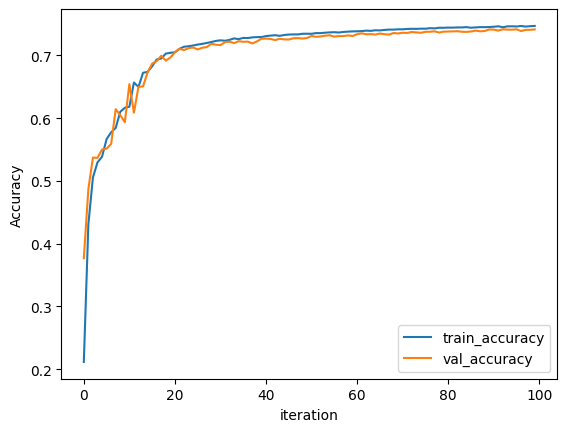

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

## Train 7

In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(300):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    print(f"Epoch {epoch+1}/{300}, Train_Loss: {t_loss:.4f}, Train_Acc: {t_acc:.4f}, Validation Loss: {v_loss:.4f}, Val_Acc: {v_acc:.4f}")

Epoch 1/300, Train_Loss: 2.0225, Train_Acc: 0.4121, Validation Loss: 1.7745, Val_Acc: 0.6041
Epoch 2/300, Train_Loss: 1.6273, Train_Acc: 0.6274, Validation Loss: 1.5108, Val_Acc: 0.6529
Epoch 3/300, Train_Loss: 1.4257, Train_Acc: 0.6619, Validation Loss: 1.3590, Val_Acc: 0.6708
Epoch 4/300, Train_Loss: 1.3021, Train_Acc: 0.6743, Validation Loss: 1.2608, Val_Acc: 0.6839
Epoch 5/300, Train_Loss: 1.2188, Train_Acc: 0.6853, Validation Loss: 1.1917, Val_Acc: 0.6787
Epoch 6/300, Train_Loss: 1.1569, Train_Acc: 0.6889, Validation Loss: 1.1397, Val_Acc: 0.6877
Epoch 7/300, Train_Loss: 1.1104, Train_Acc: 0.6927, Validation Loss: 1.0994, Val_Acc: 0.6867
Epoch 8/300, Train_Loss: 1.0731, Train_Acc: 0.6948, Validation Loss: 1.0670, Val_Acc: 0.6887
Epoch 9/300, Train_Loss: 1.0427, Train_Acc: 0.7000, Validation Loss: 1.0400, Val_Acc: 0.6882
Epoch 10/300, Train_Loss: 1.0172, Train_Acc: 0.7007, Validation Loss: 1.0171, Val_Acc: 0.6958
Epoch 11/300, Train_Loss: 0.9952, Train_Acc: 0.7048, Validation Loss:

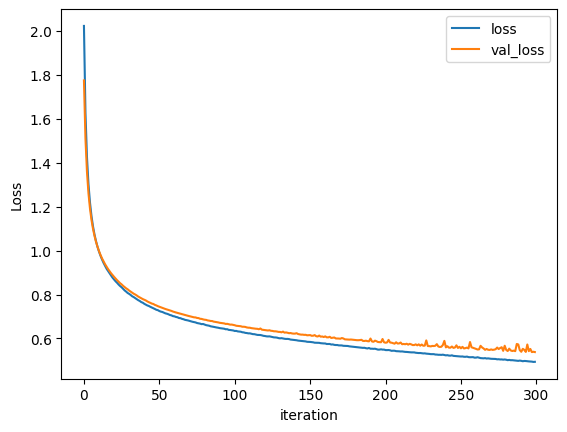

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

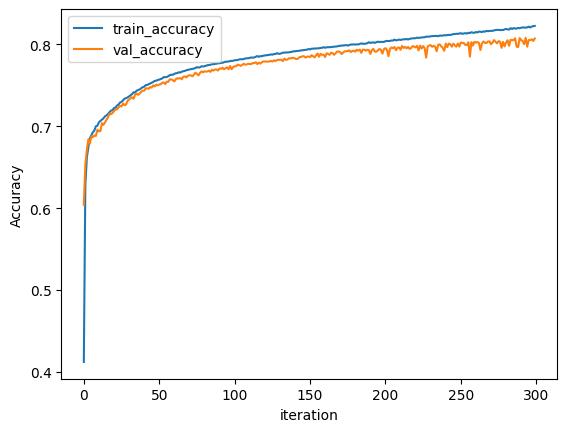

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()